In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset,DataLoader
from torch.nn import init
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_inputs,num_example = 200,10000
x1 = torch.normal(2,1,(num_example,num_inputs))
y1 = torch.ones((num_example,1))
x2 = torch.normal(-2,1,(num_example,num_inputs))
y2 = torch.zeros((num_example,1))
x_data = torch.cat((x1,x2),dim=0)
y_data = torch.cat((y1,y2),dim = 0)
train_x,test_x,train_y,test_y = train_test_split(x_data,y_data,shuffle=True,test_size=0.3,stratify=y_data)

In [3]:
batch_size = 256
train_dataset = TensorDataset(train_x,train_y)
train_iter = DataLoader(
    dataset = train_dataset,
    shuffle = True,
    num_workers = 0,
    batch_size = batch_size
)
test_dataset = TensorDataset(test_x,test_y)
test_iter = DataLoader(
    dataset = test_dataset,
    shuffle = True,
    num_workers = 0,
    batch_size = batch_size
)

In [4]:
num_hidden,num_output = 256,1
torch.set_default_tensor_type = torch.float32
# w1 = torch.tensor(torch.normal(0,0.001,size = (num_hidden,num_input))).type(torch.float32)
w1 = torch.tensor(torch.normal(0,0.001,size = (num_hidden,num_inputs))).type(torch.FloatTensor)
b1 = torch.ones(1)
# b1 = torch.ones(1,dtype = torch.float32)
print(w1.dtype)
print(b1.dtype)

w2 = torch.tensor(torch.normal(0,0.001,size = (num_output,num_hidden)),dtype = torch.float32)
b2 = torch.ones(1)
params = [w1,w2,b1,b2]

for param in params:
    param.requires_grad_(requires_grad=True)

torch.float32
torch.float32


E:\anaconda\envs\dl\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
E:\anaconda\envs\dl\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [5]:
def ReLU(x):
    return torch.max(x,other = torch.tensor(0.0))

loss = nn.BCEWithLogitsLoss()
# loss = nn.BCELoss()
def net(x):
    H1 = ReLU(torch.matmul(x,w1.t())+b1)
    H2 = torch.matmul(H1,w2.t())+b2
    return H2

def SGD(params,lr):
    param.data -= lr*param.grad/batch_size

In [6]:
def train(net ,train_iter,test_iter,lr,num_epochs,params):
    train_l,test_l = [],[]
    for epoch in range(num_epochs):
        train_l_sum,n = 0,0
        for x,y in train_iter:
            n += y.shape[0]
            y_pred = net(x)
            l = loss(y_pred,y)
            train_l_sum += l.item()
            if params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()

            l.backward()
            SGD(params,lr)
        train_l.append(train_l_sum/n)

        test_l_sum,n = 0,0
        for x,y in test_iter:
            n += y.shape[0]
            y_pred = net(x)
            l = loss(y_pred,y)
            test_l_sum += l.item()
        test_l.append(test_l_sum/n)
        print('epoch %d, train_loss %.6f,test_loss %.6f'%(epoch+1, train_l[epoch],test_l[epoch]))
    return train_l,test_l

In [15]:
lr,num_epochs = 0.01,10
train_loss,test_loss =train(net ,train_iter,test_iter,lr,num_epochs,params)

epoch 1, train_loss 0.003188,test_loss 0.003245
epoch 2, train_loss 0.003188,test_loss 0.003242
epoch 3, train_loss 0.003188,test_loss 0.003247
epoch 4, train_loss 0.003188,test_loss 0.003255
epoch 5, train_loss 0.003187,test_loss 0.003247
epoch 6, train_loss 0.003187,test_loss 0.003251
epoch 7, train_loss 0.003185,test_loss 0.003241
epoch 8, train_loss 0.003185,test_loss 0.003244
epoch 9, train_loss 0.003187,test_loss 0.003237
epoch 10, train_loss 0.003187,test_loss 0.003239


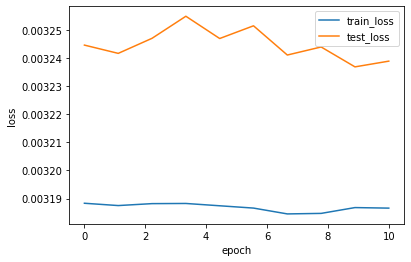

In [16]:
x = np.linspace(0,len(train_loss),len(train_loss))
plt.plot(x,train_loss,label="train_loss",linewidth=1.5)
plt.plot(x,test_loss,label="test_loss",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [7]:
num_input,num_hidden,num_output = 200,256,1
class net(nn.Module):
    def __init__(self,num_input,num_hidden,num_output):
        super(net,self).__init__()
        self.linear1 = nn.Linear(num_input,num_hidden,bias =False)
        self.linear2 = nn.Linear(num_hidden,num_output,bias=False)
    def forward(self,input):
        out = self.linear1(input)
        out = self.linear2(out)
        return out

In [8]:
model = net(num_input,num_hidden,num_output)
print(model)

net(
  (linear1): Linear(in_features=200, out_features=256, bias=False)
  (linear2): Linear(in_features=256, out_features=1, bias=False)
)


In [9]:
for param in model.parameters():
    init.normal_(param,mean=0,std=0.001)

In [10]:
lr = 0.001
loss = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(),lr)
def train(net,train_iter,test_iter,loss,num_epochs,batch_size):
    train_ls,test_ls,train_acc,test_acc = [],[],[],[]
    for epoch in range(num_epochs):
        train_ls_sum,train_acc_sum,n = 0,0,0
        for x,y in train_iter:
            y_pred = model(x)
            l = loss(y_pred,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_ls_sum +=l.item()
            train_acc_sum += (((y_pred>0.5)==y)+0.0).sum().item()
            n += y_pred.shape[0]
        train_ls.append(train_ls_sum)
        train_acc.append(train_acc_sum/n)

        test_ls_sum,test_acc_sum,n = 0,0,0
        for x,y in test_iter:
            y_pred = model(x)
            l = loss(y_pred,y)
            test_ls_sum +=l.item()
            test_acc_sum += (((y_pred>0.5)==y)+0.0).sum().item()
            n += y_pred.shape[0]
        test_ls.append(test_ls_sum)
        test_acc.append(test_acc_sum/n)
        print('epoch %d, train_loss %.6f,test_loss %f, train_acc %.6f,test_acc %f'
              %(epoch+1, train_ls[epoch],test_ls[epoch], train_acc[epoch],test_acc[epoch]))
    return train_ls,test_ls,train_acc,test_acc

In [8]:
#训练次数和学习率
num_epochs = 10
train_loss,test_loss,train_acc,test_acc = train(model,train_iter,test_iter,loss,num_epochs,batch_size)

epoch 1, train_loss 37.955347,test_loss 16.447831, train_acc 0.500000,test_acc 0.500000
epoch 2, train_loss 37.087444,test_loss 15.746473, train_acc 0.500000,test_acc 0.500000
epoch 3, train_loss 33.748711,test_loss 13.178669, train_acc 0.500000,test_acc 0.500000
epoch 4, train_loss 24.513280,test_loss 7.868286, train_acc 0.803429,test_acc 1.000000
epoch 5, train_loss 12.777908,test_loss 3.694213, train_acc 1.000000,test_acc 1.000000
epoch 6, train_loss 6.158469,test_loss 1.916471, train_acc 1.000000,test_acc 1.000000
epoch 7, train_loss 3.437311,test_loss 1.166390, train_acc 1.000000,test_acc 1.000000
epoch 8, train_loss 2.213048,test_loss 0.796750, train_acc 1.000000,test_acc 1.000000
epoch 9, train_loss 1.570772,test_loss 0.587893, train_acc 1.000000,test_acc 1.000000
epoch 10, train_loss 1.190599,test_loss 0.457967, train_acc 1.000000,test_acc 1.000000


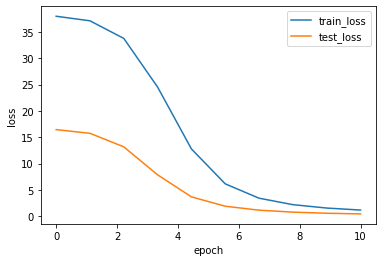

In [9]:
x = np.linspace(0,len(train_loss),len(train_loss))
plt.plot(x,train_loss,label="train_loss",linewidth=1.5)
plt.plot(x,test_loss,label="test_loss",linewidth=1.5)

plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

k

In [19]:
def get_data_iter(X_train, y_train, X_valid, y_valid,batch_size):
    train_dataset = torch.utils.data.TensorDataset(X_train,y_train)
    test_dataset = torch.utils.data.TensorDataset(X_valid,y_valid)
    train_iter = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    test_iter = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
    return train_iter, test_iter

In [20]:
def get_kfold_data(k, i, X, y):
    fold_size = X.shape[0] // k
    val_start = i * fold_size
    if i != k - 1:
        val_end = (i + 1) * fold_size
        X_valid, y_valid = X[val_start:val_end], y[val_start:val_end]
        X_train = torch.cat((X[0:val_start], X[val_end:]), dim=0)
        y_train = torch.cat((y[0:val_start], y[val_end:]), dim=0)
    else:
        X_valid, y_valid = X[val_start:], y[val_start:]
        X_train = X[0:val_start]
        y_train = y[0:val_start]

    return X_train, y_train, X_valid, y_valid


def k_fold(k, X_train, y_train, if_reshape, num_epochs, num_inputs, net, loss):
    my_k_train_ls, my_k_valid_ls,my_k_train_ac ,my_k_valid_ac= [], [],[],[]
    train_loss_sum, valid_loss_sum,train_ac_sum, valid_ac_sum = 0, 0,0,0
    for i in range(k):
        print('第', i + 1, '折验证结果')
        X_train, y_train, X_valid, y_valid = get_kfold_data(k, i, X_train, y_train)
        train_iter, valid_iter = get_data_iter(X_train, y_train, X_valid, y_valid, batch_size=100)
        train_loss, val_loss ,train_acc,test_acc= train(net,train_iter,test_iter,loss,num_epochs,batch_size)
        my_k_train_ls.append(train_loss)
        my_k_valid_ls.append(val_loss)
        train_loss_sum += train_loss[-1]
        valid_loss_sum += val_loss[-1]
        my_k_train_ac.append(train_acc)
        my_k_valid_ac.append(test_acc)
        train_ac_sum += train_acc[-1]
        valid_ac_sum += test_acc[-1]

    print("最终平均k折交叉验证结果")

    print(f'average train loss: {train_loss_sum / k}')
    print(f'average valid loss: {valid_loss_sum / k}')
    print(f'average train ac: {train_ac_sum / k}')
    print(f'average valid ac: {valid_ac_sum / k}')

    return my_k_train_ls, my_k_valid_ls,my_k_train_ac, my_k_valid_ac

In [21]:
k=10
mynum_epochs= 20
num_inputs,num_outputs,num_hiddens = 500,1,256
num_input, num_hidden, num_output = 200, 256, 1


class net(nn.Module):
    def __init__(self, num_input, num_hidden, num_output):
        super(net, self).__init__()
        self.linear1 = nn.Linear(num_input, num_hidden, bias=False)
        self.linear2 = nn.Linear(num_hidden, num_output, bias=False)

    def forward(self, input):
        out = self.linear1(input)
        out = self.linear2(out)
        return out


mynet = net(num_input, num_hidden, num_output)
MSEloss= nn.MSELoss()

# record_k_train_ls, record_k_valid_ls = k_fold(k, X_train, y_train,if_reshape=False,num_epochs=20,num_inputs,net ,loss)
my_k_train_ls, my_k_valid_ls,my_k_train_ac, my_k_valid_ac = k_fold(k,x_data,y_data,if_reshape=False,num_epochs=mynum_epochs,num_inputs = 500,net =mynet,loss= MSEloss)

第 1 折验证结果
epoch 1, train_loss 44.390351,test_loss 6.055752, train_acc 0.555944,test_acc 0.501000
epoch 2, train_loss 44.387310,test_loss 6.097028, train_acc 0.556000,test_acc 0.500000
epoch 3, train_loss 44.375495,test_loss 6.052972, train_acc 0.556556,test_acc 0.500833
epoch 4, train_loss 44.376973,test_loss 6.112727, train_acc 0.555889,test_acc 0.500000
epoch 5, train_loss 44.371718,test_loss 6.024490, train_acc 0.555833,test_acc 0.505000
epoch 6, train_loss 44.369344,test_loss 6.045775, train_acc 0.556278,test_acc 0.501667
epoch 7, train_loss 44.357184,test_loss 6.058902, train_acc 0.557111,test_acc 0.500333
epoch 8, train_loss 44.362631,test_loss 6.049979, train_acc 0.556389,test_acc 0.501667
epoch 9, train_loss 44.356753,test_loss 6.069148, train_acc 0.556500,test_acc 0.500167
epoch 10, train_loss 44.353687,test_loss 6.045936, train_acc 0.556111,test_acc 0.501167
epoch 11, train_loss 44.344511,test_loss 6.093458, train_acc 0.556389,test_acc 0.500167
epoch 12, train_loss 44.348868,

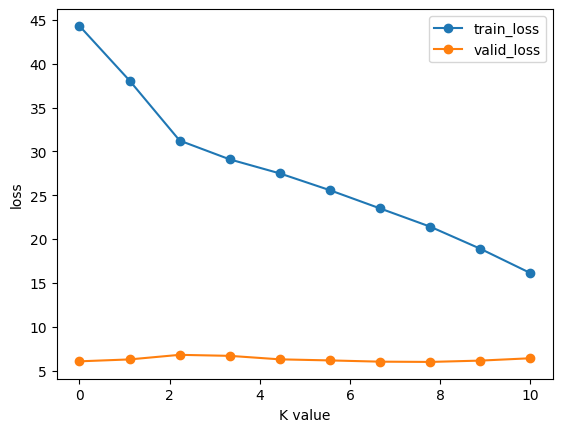

In [22]:
train_loss, valid_loss = [], []
for i in range(len(my_k_train_ls)):
    train_loss.append(my_k_train_ls[i][-1])
    valid_loss.append(my_k_valid_ls[i][-1])

x = np.linspace(0,len(my_k_train_ls),len(my_k_train_ls))
plt.plot(x,train_loss,'o-',label='train_loss',linewidth=1.5)
plt.plot(x,valid_loss,'o-',label='valid_loss',linewidth=1.5)
plt.xlabel('K value')
plt.ylabel('loss')
plt.legend()
plt.show()

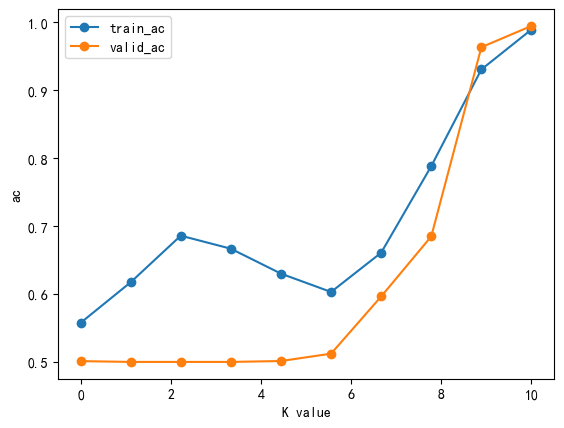

In [24]:
train_ac, valid_ac = [], []
for i in range(len(my_k_train_ac)):
    train_ac.append(my_k_train_ac[i][-1])
    valid_ac.append(my_k_valid_ac[i][-1])

x = np.linspace(0,len(my_k_train_ac),len(my_k_train_ac))
plt.plot(x,train_ac,'o-',label='train_ac',linewidth=1.5)
plt.plot(x,valid_ac,'o-',label='valid_ac',linewidth=1.5)
plt.xlabel('K value')
plt.ylabel('ac')
plt.legend()
plt.show()

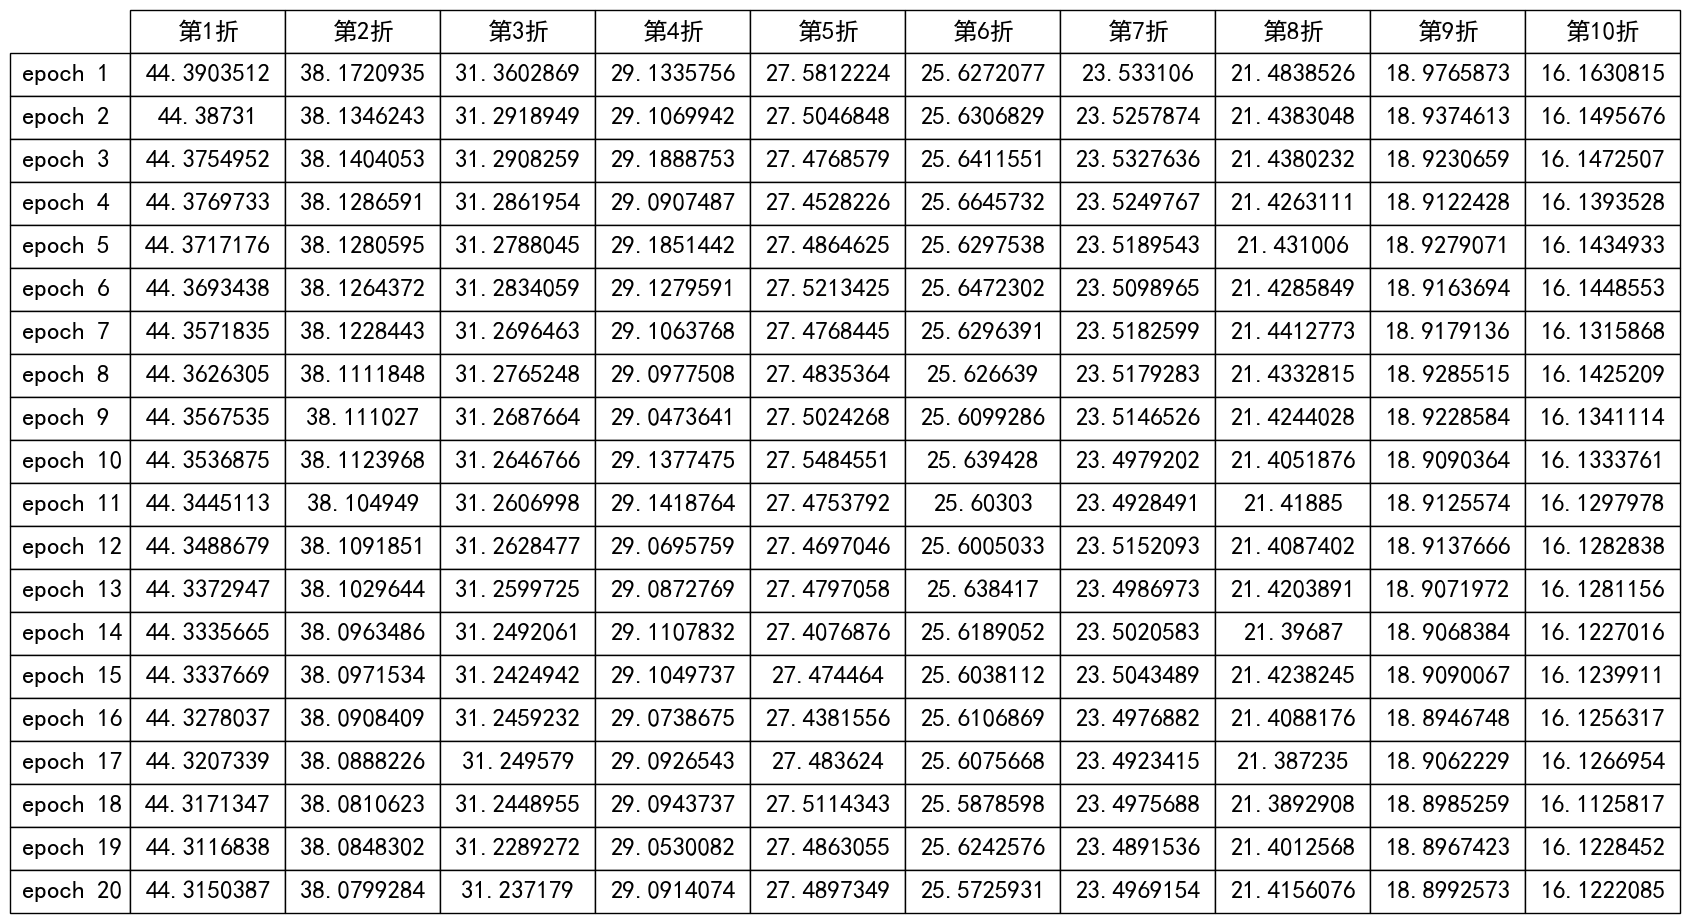

In [23]:
import pandas as pd
# 绘制表格
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
randn = np.random.randn
idx = []
for i in range(1,21):
    idx.append(f'epoch {i}')

data_train, data_valid = np.zeros((10,20)),np.zeros((10,20))
for i in range(10):
    for j in range(20):
        data_train[i,j], data_valid[i,j] = my_k_train_ls[i][j], my_k_valid_ls[i][j]

df = pd.DataFrame(data_train.T, index=idx, columns=['第1折', '第2折', '第3折', '第4折', '第5折',
                                                '第6折', '第7折', '第8折', '第9折', '第10折'])

vals = np.around(df.values,7)
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])
the_table=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns,
                    colWidths = [0.1]*vals.shape[1], loc='center',cellLoc='center')
the_table.set_fontsize(20)

the_table.scale(2.5,2.58)